<a href="https://colab.research.google.com/github/baicheto/AML_Bitcoin/blob/Kri/AML_node2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Anti-Money Launderig - Elliptic dataset**
- The dataset is a transaction graph collected from the Bitcoin blockchain. A node in the graph represents a transaction, an edge can be viewed as a flow of Bitcoins between one transaction and the other. Each node has 166 features and has been labeled as being created by a "licit", "illicit" or "unknown" entity.
- The graph is made of 203,769 nodes and 234,355 edges. Two percent (4,545) of the nodes are labelled class1 (illicit). Twenty-one percent (42,019) are labelled class2 (licit). The remaining transactions are not labelled with regard to licit versus illicit.



In [1]:
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/AML/elliptic_bitcoin_dataset'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install torch_geometric

In [3]:


import os

import numpy as np
import pandas as pd
import random
import torch
import torch_geometric
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community as community_louvain
import torch.nn.functional as F


from torch import Tensor
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from scipy.stats import ttest_ind

print("Torch version:", torch.__version__)
print("Torch Geometric version:", torch_geometric.__version__)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=mpl.MatplotlibDeprecationWarning)

Torch version: 2.6.0+cu124
Torch Geometric version: 2.6.1


#### 1. Read the files

In [4]:
features = pd.read_csv('/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
edges = pd.read_csv('/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
classes = pd.read_csv('/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')


In [5]:
trans_features = ["trans_feat_"+str(i) for i in range(2,95)]
agg_features = ["agg_feat_"+str(i) for i in range(1,73)]
features.columns = ["txId","time_step"] + trans_features + agg_features

print(f"""Shapes
{4*' '}Features : {features.shape[0]:8,} (rows)  {features.shape[1]:4,} (cols)
{4*' '}Classes  : {classes.shape[0]:8,} (rows)  {classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {edges.shape[0]:8,} (rows)  {edges.shape[1]:4,} (cols)
""")


Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



In [6]:
features.head()

,txId,time_step,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,agg_feat_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [7]:
edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [8]:
classes.head()

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


Map the illicit, licit, unknown transactions to 1, 2 and 0 respectively

In [9]:
#classes['class'] = classes['class'].replace({'unknown': 0, '1': 1, '2': 2})
classes['class'] = classes['class'].replace({'1': '1', '2': '2', 'unknown': '3'})

percentage_distribution = round(100 * classes['class'].value_counts(normalize=True), 2)
class_counts = classes['class'].value_counts()

In [10]:
classes

,txId,class
0,230425980,3
1,5530458,3
2,232022460,3
3,232438397,2
4,230460314,3
...,...,...
203764,173077460,3
203765,158577750,3
203766,158375402,1
203767,158654197,3


In [11]:
classes_df = classes[['txId', 'class']].copy()
classes_df['Percentage'] = classes_df['class'].map(percentage_distribution)
classes_df['Counts'] = classes_df['class'].map(class_counts)

In [12]:
classes_df

,txId,class,Percentage,Counts
0,230425980,3,77.15,157205
1,5530458,3,77.15,157205
2,232022460,3,77.15,157205
3,232438397,2,20.62,42019
4,230460314,3,77.15,157205
...,...,...,...,...
203764,173077460,3,77.15,157205
203765,158577750,3,77.15,157205
203766,158375402,1,2.23,4545
203767,158654197,3,77.15,157205


**EDA**

Let's create a NetworkX graph G from the edge list, where:

Each node is a Bitcoin transaction (txId1, txId2).

Each edge represents a transaction flow between two transactions (a directed connection in practice)

In [13]:
# ✅ STEP 1 — Merge class labels into features
features = pd.merge(features, classes[['txId', 'class']], on='txId', how='left')

In [14]:
# ✅ STEP 2 — Create label mapping and attach to graph nodes
label_dict = dict(zip(features['txId'], features['class']))

In [15]:
# Let's create a graph
G = nx.from_pandas_edgelist(edges, 'txId1', 'txId2')

In [16]:
# Attach labels to graph nodes
nx.set_node_attributes(G, label_dict, 'label')

In [17]:
# Example: Print label for a few nodes
for node in list(G.nodes)[:10]:
    print(f"Transaction {node} is labeled as:", G.nodes[node].get('label', 'No label'))


Transaction 230425980 is labeled as: 3
Transaction 5530458 is labeled as: 3
Transaction 232022460 is labeled as: 3
Transaction 232438397 is labeled as: 2
Transaction 230460314 is labeled as: 3
Transaction 230459870 is labeled as: 3
Transaction 230333930 is labeled as: 3
Transaction 230595899 is labeled as: 3
Transaction 232013274 is labeled as: 3
Transaction 232029206 is labeled as: 2


In [18]:
from collections import Counter
graph_labels = [G.nodes[n].get('label', 'missing') for n in G.nodes()]
print(Counter(graph_labels))


Counter({'3': 157205, '2': 42019, '1': 4545})


Those txIds exist in your edge list (i.e., they're in the graph),

But they don’t exist in your merged features + class labels DataFrame,

So they were never added to your label_dict, which leads to nan when you query their labels.



Filter the edge list to include only transactions that are present in the labeled feature set
Every node in the graph will have a txId that also exists in the merged data.

In [19]:
known_txs = features['txId'].unique()
edges = edges[edges['txId1'].isin(known_txs) & edges['txId2'].isin(known_txs)]

In [20]:
G1 = nx.from_pandas_edgelist(edges, 'txId1', 'txId2')

In [21]:
label_dict = dict(zip(features['txId'], features['class']))
nx.set_node_attributes(G1, label_dict, 'label')


In [22]:
# Example: Print label for a few nodes
for node in list(G1.nodes)[:10]:
    print(f"Transaction {node} is labeled as:", G1.nodes[node].get('label', 'No label'))


Transaction 230425980 is labeled as: 3
Transaction 5530458 is labeled as: 3
Transaction 232022460 is labeled as: 3
Transaction 232438397 is labeled as: 2
Transaction 230460314 is labeled as: 3
Transaction 230459870 is labeled as: 3
Transaction 230333930 is labeled as: 3
Transaction 230595899 is labeled as: 3
Transaction 232013274 is labeled as: 3
Transaction 232029206 is labeled as: 2


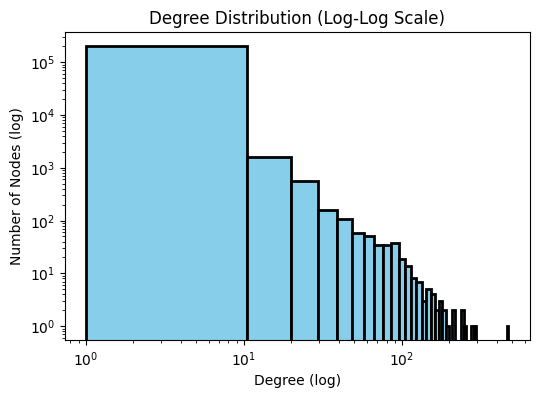

In [23]:
plt.figure(figsize=(6, 4))
degrees = [G1.degree(n) for n in G1.nodes()]
plt.hist(degrees, bins=50, log=True, color='skyblue', edgecolor='black', linewidth=2.0)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree (log)')
plt.ylabel('Number of Nodes (log)')
plt.show()

This graph shows that the network has a heavy-tailed degree distribution.

A few transactions interact with many others — potential hubs.

Most transactions interact with very few others.

The results are pretty common for financial-transaction graphs

In [24]:
num_connected_components = nx.number_connected_components(G1)
print(f"Number of connected components: {num_connected_components}")

Number of connected components: 49


In [25]:
# Giant component analysis (largest connected cluster)
giant_component = max(nx.connected_components(G1), key=len)
G_giant = G.subgraph(giant_component)

print(f"Giant component - Number of nodes: {G_giant.number_of_nodes():,}")
print(f"Giant component - Number of edges: {G_giant.number_of_edges():,}")

Giant component - Number of nodes: 7,880
Giant component - Number of edges: 9,164


**Node centrality measures**

Degree centrality
- measures the number of direct connections a node has in a network. It is defined as the number of edges connected to a node.
A node with a high degree centrality is highly connected and may play a crucial role in the network by having direct interactions with many other nodes.

In [26]:

# Degree centrality.
degree_centrality = nx.degree_centrality(G_giant)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_degree_centrality = pd.DataFrame(top_degree_centrality, columns=['Node', 'Degree Centrality'])

# Subgraph of top nodes
top_nodes_by_ = df_top_degree_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)

# Get node colors based on centrality
node_color = [degree_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
cmap = plt.cm.cool

# Create scalar mappable for the colorbar
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])


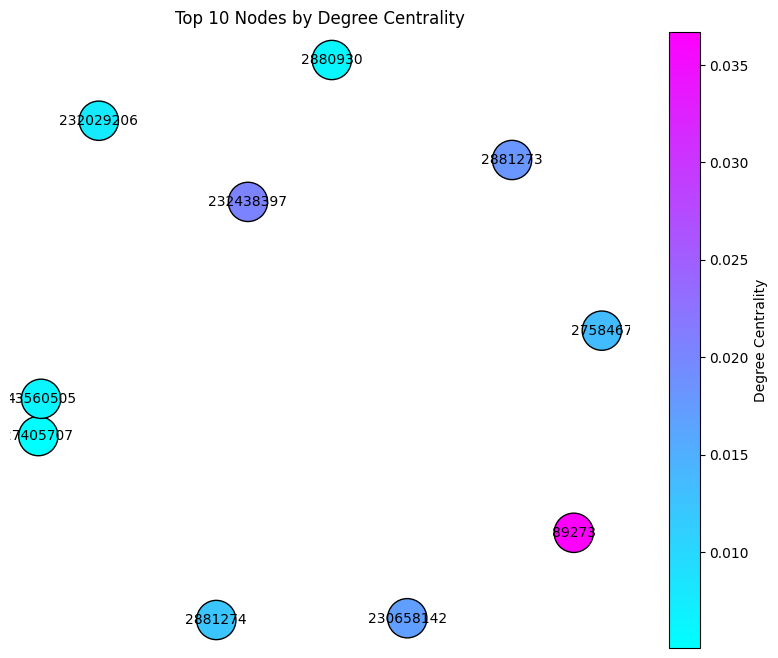

In [27]:
# Plot
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)

nx.draw_networkx_nodes(subgraph, pos, node_color=node_color, cmap=cmap, node_size=800, edgecolors='black')
nx.draw_networkx_edges(subgraph, pos)
nx.draw_networkx_labels(subgraph, pos, font_size=10)

plt.colorbar(sm, label='Degree Centrality', ax=plt.gca())
plt.title('Top 10 Nodes by Degree Centrality')
plt.axis('off')
plt.show()


2. Betweeness Centrality
- Betweenness centrality measures the extent to which a node lies on the shortest paths between other nodes in the network.

- A node with high betweenness centrality has significant control over the flow of information or resources in the network because it connects different parts of the network. It often indicates a node that is critical for communication.

In [28]:
# Betweenness centrality.
betweenness_centrality = nx.betweenness_centrality(G_giant)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_betweenness_centrality = pd.DataFrame(top_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

print("Top 10 nodes by betweenness centrality:")
print("=======================================")
print(df_top_betweenness_centrality)

top_nodes_by_ = df_top_betweenness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)
node_color = [betweenness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

Top 10 nodes by betweenness centrality:
        Node  Betweenness Centrality
0      89273                0.485234
1  232438397                0.296735
2    2758467                0.164410
3    2881273                0.156171
4    2881274                0.135059
5    2893846                0.104127
6  230402893                0.092297
7  230658142                0.087068
8   34174548                0.081942
9    2880930                0.078085


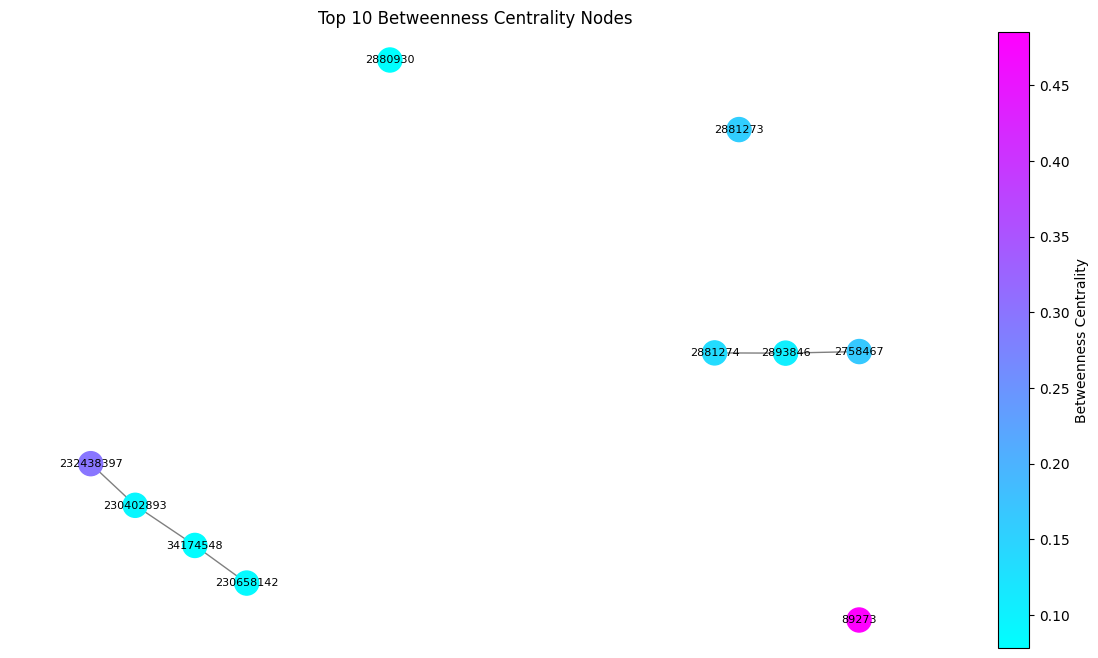

In [29]:
fig, ax = plt.subplots(figsize=(15, 8))
pos = nx.spring_layout(subgraph, seed=42)

nodes = nx.draw_networkx_nodes(subgraph, pos,
                               node_color=node_color,
                               cmap=cmap,
                               node_size=300,
                               ax=ax)
nx.draw_networkx_edges(subgraph, pos, ax=ax, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, ax=ax, font_size=8)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Betweenness Centrality')

ax.set_title('Top 10 Betweenness Centrality Nodes')
ax.axis('off')
plt.show()

3. Closeness Centrality
- Closeness centrality measures how close a node is to all other nodes in the network. It is the reciprocal of the sum of the shortest path distances from the node to all other nodes in the network.
-  A node with high closeness centrality can quickly interact with all other nodes and can be an effective spreader of information or influence throughout the network.

In [30]:
# Closeness centrality.
closeness_centrality = nx.closeness_centrality(G_giant)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_closeness_centrality = pd.DataFrame(top_closeness_centrality, columns=['Node', 'Closeness Centrality'])

print("Top 10 nodes by closeness centrality:")
print("=====================================")
print(df_top_closeness_centrality)

top_nodes_by_closeness = df_top_closeness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_closeness)
node_color = [closeness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool


Top 10 nodes by closeness centrality:
        Node  Closeness Centrality
0      89273              0.162511
1  232438397              0.155365
2  230438845              0.151394
3  230439793              0.151394
4  230683551              0.149009
5  230537117              0.148888
6  230451730              0.147738
7  232031824              0.146728
8  203465969              0.146725
9  232054853              0.146205


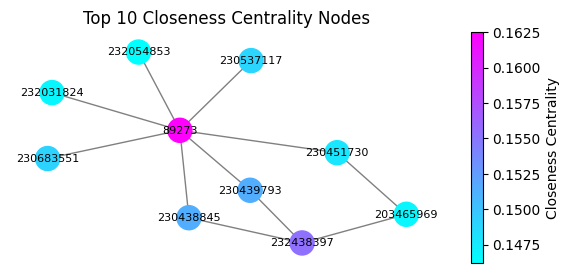

In [31]:
fig, ax = plt.subplots(figsize=(7, 3))
pos = nx.spring_layout(subgraph, seed=42)

nodes = nx.draw_networkx_nodes(
    subgraph, pos,
    node_color=node_color,
    cmap=cmap,
    node_size=300,
    ax=ax
)
nx.draw_networkx_edges(subgraph, pos, ax=ax, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, ax=ax, font_size=8)

# Create colorbar from scalar mappable
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Closeness Centrality')

ax.set_title('Top 10 Closeness Centrality Nodes')
ax.axis('off')
plt.show()

Check what kind of a node is 89273

In [32]:
# List of your top transaction IDs
top_tx_ids = [232438397]

# Iterate over each txId and check its class
for tx_id in top_tx_ids:
    label_row = classes[classes['txId'] == tx_id]

    if not label_row.empty:
        label = label_row['class'].values[0]
        print(f"Transaction {tx_id} is labeled as:", end=" ")
        if label == '1':
            print("Illicit")
        elif label == '2':
            print("Licit")
        else:
            print("Unknown")
    else:
        print(f"Transaction ID {tx_id} not found in class labels.")


Transaction 232438397 is labeled as: Licit


In [33]:
print(classes['txId'].dtype)
print(type(232438397))

int64
<class 'int'>


In [34]:
classes['txId'] = classes['txId'].astype(int)


In [35]:
print(classes.shape)
print(classes['txId'].nunique())
print(232438397 in classes['txId'].values)


(203769, 2)
203769
True


In [36]:
top_tx_ids = [89273, 232438397, 230438845, 230439793, 230683551,
              230537117, 230451730, 232031824, 203465969, 232054853]

# Ensure txId column is int (to match your tx_ids)
classes['txId'] = classes['txId'].astype(int)

# Loop with improved handling
for tx_id in top_tx_ids:
    label_row = classes[classes['txId'] == tx_id]

    if not label_row.empty:
        label = label_row['class'].values[0]
        print(f"Transaction {tx_id} is labeled as:", end=" ")
        if label == '1':
            print("Illicit")
        elif label == '2':
            print("Licit")
        else:
            print("Unknown")
    else:
        print(f"Transaction ID {tx_id} not found in class labels.")


Transaction 89273 is labeled as: Licit
Transaction 232438397 is labeled as: Licit
Transaction 230438845 is labeled as: Licit
Transaction 230439793 is labeled as: Licit
Transaction 230683551 is labeled as: Licit
Transaction 230537117 is labeled as: Unknown
Transaction 230451730 is labeled as: Licit
Transaction 232031824 is labeled as: Licit
Transaction 203465969 is labeled as: Unknown
Transaction 232054853 is labeled as: Licit


**We can see that 80% of our top 10 nodes are licit transactions**

**Class-specific analysis**

In [37]:
# Class-based subgraphs
illicit_nodes = classes_df[classes_df['class'] == '1']['txId']
licit_nodes = classes_df[classes_df['class'] == '2']['txId']

G_illicit = G.subgraph(illicit_nodes)
G_licit = G.subgraph(licit_nodes)

Text(0.5, 1.0, 'Illicit Transactions Subgraph')

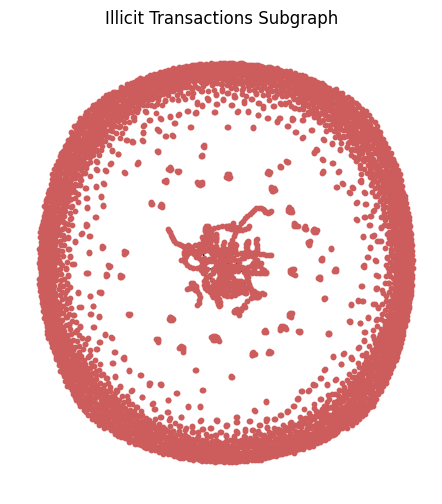

In [38]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
nx.draw(G_illicit, with_labels=False, node_size=10, node_color='indianred', edge_color='black')
plt.title('Illicit Transactions Subgraph')


In [39]:
"""
plt.subplot(1, 2, 2)
nx.draw(G_licit, with_labels=False, node_size=10, node_color='forestgreen', edge_color='black')
plt.title('Licit Transactions Subgraph')

plt.show()
"""

"\nplt.subplot(1, 2, 2)\nnx.draw(G_licit, with_labels=False, node_size=10, node_color='forestgreen', edge_color='black')\nplt.title('Licit Transactions Subgraph')\n\nplt.show()\n"

TODO:
- explore the 89273 node (show whether it is illicit, licit, unknown)
- merge features with classes
- sort tx_idx for classes and edges
- ML classify only with the transaction features and only with the aggregated ones -> compare the results ? if enough time
- For Node2Vec use (trans, agg and all features -> compare results)
- Use GIN with (trans, agg and all features -> compare results)
- Apply Deep Neural Decision Forest (suggested by prof paper) ? if enough time

In [40]:
#class_values = sorted(classes["class"].unique())

In [41]:
#tx_idx = {name: idx for idx, name in enumerate(sorted(classes["txId"].unique()))}

In [42]:
#classes["txId"] = classes["txId"].apply(lambda name: tx_idx[name])

### Node2Vec Experiment with PyTorch Geometric

In [43]:
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --extra-index-url https://data.pyg.org/whl/cpu


In [44]:
from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [45]:
# Map txId to indices
tx_idx = {name: idx for idx, name in enumerate(sorted(features['txId'].unique()))}
features['txId'] = features['txId'].map(tx_idx)
edges['txId1'] = edges['txId1'].map(tx_idx)
edges['txId2'] = edges['txId2'].map(tx_idx)

In [46]:
# Map classes to integers
class_values = sorted(features['class'].unique())
class_idx = {label: idx for idx, label in enumerate(class_values)}
features['class'] = features['class'].map(class_idx)

In [47]:
# Create edge_index
edge_index = torch.tensor(edges[['txId1', 'txId2']].values.T, dtype=torch.long)
y = torch.tensor(features['class'].values, dtype=torch.long)

In [48]:
# Placeholder x (not used in Node2Vec)
x_placeholder = torch.ones((features.shape[0], 1), dtype=torch.float)
data = Data(edge_index=edge_index, y=y, x=x_placeholder)

{'embedding_dim': 10, 'walk_length': 5, 'context_size': 4, 'walks_per_node': 1, 'num_negative_samples': 3, 'p': 1.7881226197950113, 'q': 1.521043366747092, 'lr': 0.06103470247692541, 'n_epochs': 59, 'n_epochs_decoder': 71}
AUC-PRC: 0.927806603892255

In [54]:
# Define Node2Vec model
"""
node2vec = Node2Vec(
    edge_index=edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    sparse=True
)
"""
node2vec = Node2Vec(
    edge_index=edge_index,
    embedding_dim=10,
    walk_length=5,
    context_size=4,
    walks_per_node=1,  # already minimal
    num_negative_samples=1,  # reduce for speed
    p=1.78,
    q=1.52,
    sparse=True
)

In [55]:
loader = node2vec.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)


In [56]:
for pos_rw, neg_rw in loader:
    print("Positive shape:", pos_rw.shape)
    print("Negative shape:", neg_rw.shape)
    break


Positive shape: torch.Size([256, 4])
Negative shape: torch.Size([256, 4])


In [57]:
def train_node2vec():
    node2vec.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node2vec.loss(pos_rw, neg_rw)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

In [59]:
for epoch in range(1, 6):
    loss = train_node2vec()
    print(f'Epoch {epoch}, Loss: {loss:.4f}')

Epoch 1, Loss: 2611.7466
Epoch 2, Loss: 2230.9946
Epoch 3, Loss: 2007.6865
Epoch 4, Loss: 1861.0075
Epoch 5, Loss: 1757.0716


In [60]:
# Extract embeddings
node2vec.eval()
embeddings = node2vec.embedding.weight.cpu().detach().numpy()

In [61]:
# Prepare feature sets
X_tx = features[trans_features].values
X_agg = features[agg_features].values
X_both = features[trans_features + agg_features].values
y_labels = features['class'].values

In [62]:
# Run experiments
from sklearn.model_selection import train_test_split


def run_experiment(X_features, exp_name):
    X_combined = np.concatenate([X_features, embeddings], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_labels, test_size=0.2, stratify=y_labels, random_state=42)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n📊 Results for {exp_name}:")
    print(classification_report(y_test, y_pred))

In [63]:
run_experiment(X_tx, "Transactional Features + Node2Vec")
run_experiment(X_agg, "Aggregated Features + Node2Vec")
run_experiment(X_both, "All Features + Node2Vec")


📊 Results for Transactional Features + Node2Vec:
              precision    recall  f1-score   support

           0       0.93      0.71      0.80       909
           1       0.92      0.84      0.88      8404
           2       0.95      0.98      0.97     31441

    accuracy                           0.95     40754
   macro avg       0.93      0.84      0.88     40754
weighted avg       0.95      0.95      0.94     40754


📊 Results for Aggregated Features + Node2Vec:
              precision    recall  f1-score   support

           0       0.92      0.46      0.61       909
           1       0.89      0.64      0.74      8404
           2       0.90      0.98      0.94     31441

    accuracy                           0.90     40754
   macro avg       0.90      0.69      0.76     40754
weighted avg       0.90      0.90      0.89     40754


📊 Results for All Features + Node2Vec:
              precision    recall  f1-score   support

           0       0.95      0.71      0.82   